Necessary Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers,utils
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from google.colab import drive #used to import dataset fromd drive
from sklearn.model_selection import train_test_split #used to split dataset into test and training sets

%matplotlib inline

**Get data from drive**

In [ ]:
#import data from google drive
# from google.colab import drive
# drive.mount('/content/drive')

#import data from csv into panda
dataset_path = 'path to fer2013.csv'
dataset = pd.read_csv(dataset_path, engine='python')



**Parse data to train and test sets**

Afer we load the data, we convert it into a numpy array of size 48,48,1.

In order to feed the newly created data to our model we need to preprocessit. 

- We have to add a  two new *axis*
- We have to divide our data into training and testing sets
- We need to normalize the data by dividing by max value, in our case 255
- We need to concatenate it in order to feed it to our model

In [ ]:
#Transform csv data to np array
img_array = dataset.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float32'))

#Reshape the data
img_array = np.stack(img_array, axis = 0)

img_array = np.stack(img_array, axis=0)

In [ ]:
#Get labels and coressponding emotion 
labels = dataset.emotion.values
class_names = ['ANGRY', 'DISGUST', 'FEAR', 'HAPPY', 'SAD', 'SURPRISE', 'NEUTRAL']

#Separate data for training and testing
x_train, x_test, y_train, y_test = train_test_split(img_array, labels, test_size=.1)

#Data normatlization 
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
#Concatenate data to be used in VGG16 architecture
img_input = layers.Input(shape=(48, 48, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])  

**Present some samples of our dataset**

In [ ]:
def display_digit(index, xs, ys, title):
    label = np.argmax(labels[index]) # argmax used to convert from one-hot back to numeric label
    image = xs[index].reshape([48,48]) # make sure that the data is in 2D shape
    plt.title(title+': Index: %d  Label: %d' % (index, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

display_digit(index=2, xs=x_train, ys=y_train, title='Train sample') 
display_digit(index=3, xs=x_test,  ys=y_test,  title='Test sample')  


**Importing the VGG16 architecture**

After importing and building the architecutre, we defined a callback function used in early stopping. This function will stop the training cycle when the validation accuracy stops increasing in order to prevent overfitting.
To optimize our outputs we used the *Adam* optimizer with a learning rate of 0.0001

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

#Load the VGG16 architecture into the viarbale model
model = VGG16(include_top=False, weights = "imagenet", input_shape=(48,48,1), input_tensor=img_conc)

#Loading the layers
flat1 = layers.Flatten()(model.layers[-1].output)
fc1 = layers.Dense(4096, activation='relu')(flat1)
fc2 = layers.Dense(4096, activation='relu')(fc1)
output = layers.Dense(10, activation='softmax')(fc2)

#Callback function used for EarlyStopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1, mode="max")

# define new model
model = Model(inputs=model.inputs, outputs=output)

model.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# model.summary()

**Training**

Here we declared our training cycle. In order to save time during our testing we used a training cycle of 10 epochs and a batch size of 32. We also apply the early stopping function to our training method. 

Epoch 1/10
1010/1010 [==============================] - 95s 93ms/step - loss: 1.4430 - accuracy: 0.4202 - val_loss: 1.1877 - val_accuracy: 0.5500
Epoch 2/10
1010/1010 [==============================] - 93s 93ms/step - loss: 1.1142 - accuracy: 0.5753 - val_loss: 1.0613 - val_accuracy: 0.6004
Epoch 3/10
1010/1010 [==============================] - 94s 93ms/step - loss: 0.9693 - accuracy: 0.6396 - val_loss: 1.0392 - val_accuracy: 0.6247
Epoch 4/10
1010/1010 [==============================] - 95s 94ms/step - loss: 0.8336 - accuracy: 0.6949 - val_loss: 1.0364 - val_accuracy: 0.6297
Epoch 5/10
1010/1010 [==============================] - 93s 93ms/step - loss: 0.6973 - accuracy: 0.7496 - val_loss: 1.0319 - val_accuracy: 0.6417
Epoch 6/10
1010/1010 [==============================] - 93s 92ms/step - loss: 0.5481 - accuracy: 0.8061 - val_loss: 1.0670 - val_accuracy: 0.6673
Epoch 7/10
1010/1010 [==============================] - 93s 92ms/step - loss: 0.4062 - accuracy: 0.8600 - val_loss: 1.1837 -

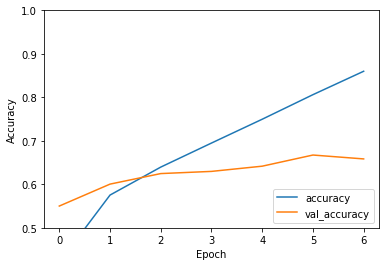

In [ ]:

history = model.fit(x_train, y_train, epochs=10, batch_size=32,
                    validation_data=(x_test, y_test), callbacks = [callback])

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print(test_acc)
model.save('/content/drive/MyDrive/Colab Notebooks/AI/model1.h5')

**Testing**

This is method of validation of our model. We display a number of images from the testing set and compare the label predicted by the model with the label associated with the image.

In [ ]:
import pdb
y_hat = model.predict(x_test)
print(y_hat)
# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 20))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=50, replace=False)):
    ax = figure.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = y_test[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))